#### Objective
- Analyze hyperspectral corn data to predict DON concentration using machine learning models.
- Data Source: MLE-Assignment.csv
- Dataset contains 5 rows × 450 columns of numerical spectral reflectance values.
- Develop a robust, modular, and production-ready ML pipeline for accurate predictions.

In [1]:
import pandas as pd
import keras_tuner as kt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

#### Setp-1 reading the data

In [2]:
data = pd.read_csv("/Users/gaurav30/Downloads/html5up-miniport/MLE-Assignment.csv")
data.head()

,hsi_id,0,1,2,3,4,5,6,7,8,...,439,440,441,442,443,444,445,446,447,vomitoxin_ppb
0,imagoai_corn_0,0.416181,0.396844,0.408985,0.372865,0.385293,0.365390,0.355226,0.343350,0.344837,...,0.710280,0.717482,0.715078,0.705379,0.696691,0.692793,0.711369,0.697679,0.704520,1100.0
1,imagoai_corn_1,0.415797,0.402956,0.402564,0.396014,0.397192,0.389634,0.375671,0.363689,0.373883,...,0.684011,0.697271,0.701995,0.696077,0.701012,0.677418,0.696921,0.696544,0.689054,1000.0
2,imagoai_corn_2,0.389023,0.371206,0.373098,0.373872,0.361056,0.349709,0.333882,0.330841,0.328925,...,0.683054,0.669286,0.663179,0.676165,0.676591,0.655951,0.658945,0.670989,0.665176,1300.0
3,imagoai_corn_3,0.468837,0.473255,0.462949,0.459335,0.461672,0.459824,0.458194,0.427737,0.415360,...,0.742782,0.730801,0.736787,0.730044,0.751437,0.738497,0.742446,0.754657,0.733474,1300.0
4,imagoai_corn_4,0.483352,0.487274,0.469153,0.487648,0.464026,0.451152,0.458229,0.440782,0.426193,...,0.770227,0.773013,0.761431,0.763488,0.762473,0.744012,0.775486,0.760431,0.751988,220.0


In [3]:
df = data.copy()

#### Step-2 Preprocssing 
- handle null values
- checking data type
- feature engineering

In [4]:
df.isnull().sum()

hsi_id           0
0                0
1                0
2                0
3                0
                ..
444              0
445              0
446              0
447              0
vomitoxin_ppb    0
Length: 450, dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Columns: 450 entries, hsi_id to vomitoxin_ppb
dtypes: float64(449), object(1)
memory usage: 1.7+ MB


In [6]:
df.dropna()

,hsi_id,0,1,2,3,4,5,6,7,8,...,439,440,441,442,443,444,445,446,447,vomitoxin_ppb
0,imagoai_corn_0,0.416181,0.396844,0.408985,0.372865,0.385293,0.365390,0.355226,0.343350,0.344837,...,0.710280,0.717482,0.715078,0.705379,0.696691,0.692793,0.711369,0.697679,0.704520,1100.0
1,imagoai_corn_1,0.415797,0.402956,0.402564,0.396014,0.397192,0.389634,0.375671,0.363689,0.373883,...,0.684011,0.697271,0.701995,0.696077,0.701012,0.677418,0.696921,0.696544,0.689054,1000.0
2,imagoai_corn_2,0.389023,0.371206,0.373098,0.373872,0.361056,0.349709,0.333882,0.330841,0.328925,...,0.683054,0.669286,0.663179,0.676165,0.676591,0.655951,0.658945,0.670989,0.665176,1300.0
3,imagoai_corn_3,0.468837,0.473255,0.462949,0.459335,0.461672,0.459824,0.458194,0.427737,0.415360,...,0.742782,0.730801,0.736787,0.730044,0.751437,0.738497,0.742446,0.754657,0.733474,1300.0
4,imagoai_corn_4,0.483352,0.487274,0.469153,0.487648,0.464026,0.451152,0.458229,0.440782,0.426193,...,0.770227,0.773013,0.761431,0.763488,0.762473,0.744012,0.775486,0.760431,0.751988,220.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,imagoai_corn_495,0.478140,0.444033,0.442120,0.437473,0.428672,0.413238,0.417758,0.420388,0.413290,...,0.747858,0.730535,0.716969,0.739297,0.724827,0.720484,0.740626,0.740116,0.721839,1200.0
496,imagoai_corn_496,0.409367,0.394941,0.380236,0.375340,0.346122,0.354650,0.361170,0.342974,0.352137,...,0.670232,0.659045,0.661587,0.658422,0.644254,0.646479,0.656779,0.646700,0.646733,0.0
497,imagoai_corn_497,0.486526,0.501372,0.500175,0.508139,0.489411,0.457311,0.462321,0.462927,0.442647,...,0.787532,0.780347,0.768362,0.771411,0.770919,0.761464,0.770314,0.763324,0.797187,0.0
498,imagoai_corn_498,0.464595,0.498822,0.489077,0.453381,0.487636,0.461950,0.461671,0.447362,0.451952,...,0.739432,0.759722,0.752118,0.761910,0.761111,0.730431,0.753545,0.749619,0.756383,0.0


#### Setp -3 spilting data 
- we spilting the data
- Standardize the target variable using StandardScaler to improve model performance.
- Apply Principal Component Analysis (PCA) to reduce dimensionality while retaining essential variance.
- Visualize the average reflectance over wavelength bands.
- Plot the distribution of DON concentration to understand its spread.

In [7]:
X = df.iloc[:, 1:-1]  
Y = df.iloc[:, -1]

In [8]:
scaler = StandardScaler()
x_sacled = scaler.fit_transform(X)


In [9]:
y_scaler = StandardScaler()
y_scaled = y_scaler.fit_transform(Y.values.reshape(-1, 1)).ravel()


In [10]:
pca = PCA(n_components=20)
x_pca = pca.fit_transform(x_sacled)


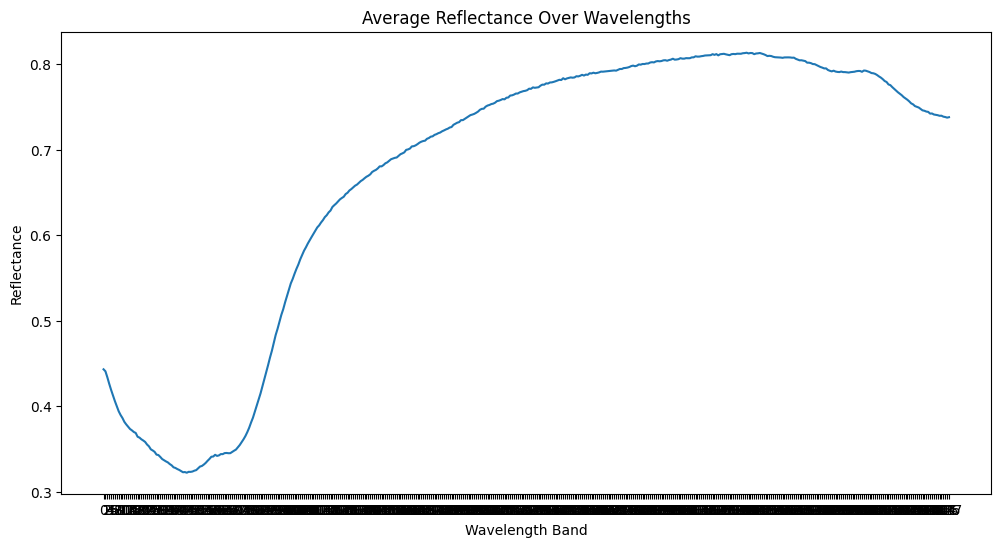

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(X.mean(axis=0))
plt.title("Average Reflectance Over Wavelengths")
plt.xlabel("Wavelength Band")
plt.ylabel("Reflectance")
plt.show()

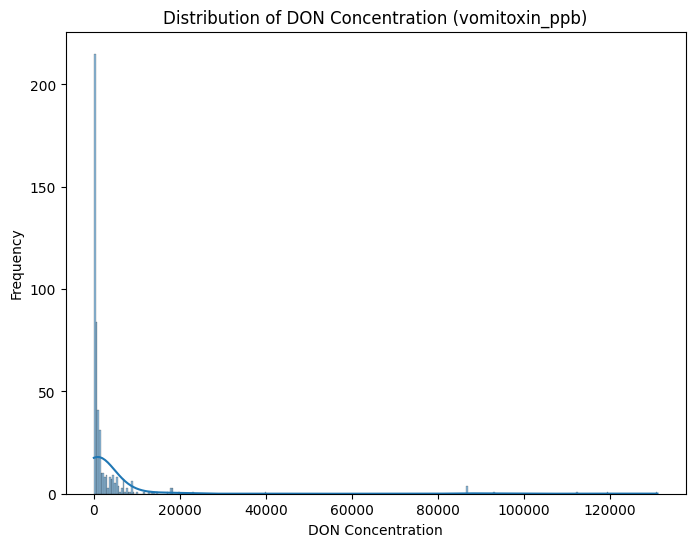

In [12]:
plt.figure(figsize=(8, 6))
sns.histplot(Y, kde=True)
plt.title("Distribution of DON Concentration (vomitoxin_ppb)")
plt.xlabel("DON Concentration")
plt.ylabel("Frequency")
plt.show()

In [13]:
X_train, X_test, y_train, y_test = train_test_split(x_pca, y_scaled, test_size=0.2, random_state=42)


#### Step-4 Model Implementation
- Reshape the data for CNN input in the format (samples, time steps, features).
- Build a CNN model for prediction.
- Print the evaluation metrics.

In [14]:

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [15]:
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    BatchNormalization(),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1)  
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')


es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32, callbacks=[es])

# Predictions
y_pred = model.predict(X_test)

# Evaluation
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f'MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}')



Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.6910 - val_loss: 1.5047
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8802 - val_loss: 1.4591
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3782 - val_loss: 1.4159
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5404 - val_loss: 1.4065
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0984 - val_loss: 1.3487
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1926 - val_loss: 1.4113
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1697 - val_loss: 1.1792
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0921 - val_loss: 1.2201
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1322 - val_loss: 1.1735
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0787 - val_loss: 1.2573
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1029 - val_loss: 1.3517
Epoch 12/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0

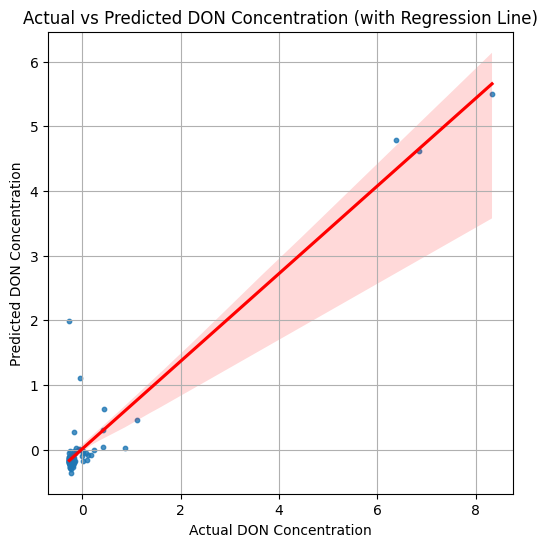

In [16]:
plt.figure(figsize=(6, 6))
sns.regplot(x=y_test, y=y_pred.flatten(), scatter_kws={'s': 10}, line_kws={"color": "red"})
plt.xlabel('Actual DON Concentration')
plt.ylabel('Predicted DON Concentration')
plt.title('Actual vs Predicted DON Concentration (with Regression Line)')
plt.grid(True)
plt.show()
